$\underline{\large{\rm Temperature-dependent\,properties\,using\,the\,ZG\,method}}$

Here we calculate temperature-dependent properties such as band strictures using the ZG method.

Below we define the main input file which defines all constants and the system we will investigate, in this case silicon.


In [1]:
import numpy as np
import math
import os
import sys
import subprocess
import EPWpy
from EPWpy import EPWpy
from EPWpy.plotting import plot_bands

####Constants########
nr=3.3
hbar=6.6*10**-16
c=3*10**10
font=16
# Supercell dimensions
dim1=3
dim2=3
dim3=3

#Define folder locations, prefix and number of cores
folder='./'
cores='16'
prefix='si'
flfrc='\''+str(prefix)+'.fc\''
pseudo = os.getcwd() + '/pseudos'
######Define the directory of installation##############
QE = '/home1/07369/mzach/codes/q-e_dev_2024/bin'
########################################################


########Define the system used for the calculations###############
silicon=EPWpy.EPWpy({'prefix':prefix,'restart_mode':'\'from_scratch\'','ibrav':2,'nat':2,'calculation':'\'scf\'',
                  'atomic_species':['Si'],'mass':[28.0855],
                  'atoms':['Si','Si'],'ntyp':1,'pseudo':['Si.upf'],'ecutwfc':'40','ecutrho':'160',
                  'celldm(1)':'10.262','verbosity':'high','type':'alat','pseudo_auto':True                  
                 },code=QE,env='ibrun')
silicon.serial = True

#######Printing any attribute######
pseudopot=silicon.__dict__['pw_atomic_species']['pseudo'][0]
print('pseudopotential:', silicon.__dict__['pw_atomic_species']['pseudo'][0])
print('pseudopotential directory:', silicon.__dict__['pw_control']['pseudo_dir'])
print('prefix:',prefix)

os.system('module list')


                                                                                                                         
                                                                                          
                                       -*#*-                             ...............- 
                          .+*=      .+%*-=%%:      .=#*-               -===============-:.
                        :*%=*%%-    *%*   #%*    :+%+-%%+             .:.  -=.   :==-.    
                        -%S  -%%*: :#%.   -%%-. -##:  #%*                  -=.   :==-     
                ..      .%S:   +%%%%*.     :*%%%#=    %%=                  -=.   :==-     
              :=#%%*-   .#S-     ..                  .%%=     :*#*:        -=.   :==-     
             -%S:.=#%%*==%#                           *%%=::=##-+%%.  .   .=-.   :==-  .= 
             :%%-   .-+++:                             -+##*=.  =%S   :-::==:    .==-  --.
              *%#                                         

0

$\underline{\large{\rm Self\,Consistent\,Field\,(SCF) \,Calculations}}$

We first solve the Kohn-Sham equations to obtain the Kohn-Sham orbitals $\phi_v(r)$, $r$ is the electronic position (generally a mesh grid), $R$ is the position of ions.

$E[\phi_v,R]=-\frac{\hbar^2}{2m}\sum_v{\int{\phi_v^\star(r)\nabla^2\phi_v(r)dr}+\int{V_R(r)n(r)dr}+\frac{e^2}{2}\int{\frac{n(r)n(r')}{|r-r'|}drdr'}+E_{xc}[n(r')]+\sum_{I\neq J}{\frac{e^2}{2}\frac{Z_IZ_J}{|R_I-R_J|}}}$

We minimize $E(R)=min(E[\phi_v,R])$

Where, $\Big(-\frac{\hbar^2}{2m}\nabla^2+V_{KS}(r)\Big)\phi_v(r)=\epsilon_v\phi_v(r)$


In [2]:
## Create SCF input file ##
silicon.scf(electrons={'conv_thr':'1E-6',
                       'mixing_beta':'0.7'},
            kpoints={'kpoints':[[6,6,6]],
                     'kpoints_type':'automatic'},
            name='scf')
## Prepare folders and copy necessary files ##
silicon.prepare(1,type_run='scf')
## Run calculation ##
silicon.run(2)

-- -- -- -- -- -- -- -- -- -- --  Calculation: scf  -- -- -- -- -- -- -- -- -- -- -- 
Running scf |████████████████████████████████████████| in 0.0s (193.46/s) 

-- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- 


In [10]:
silicon.file = 'si/scf/scf.out'
silicon.get_QE_status()

-- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- 
Calculation finished normally in si/scf/scf.out

-- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- 


$\underline{\large{\rm Phonon\,Calculations}}$

In order to obtain the temperature-dependent properties we need the electron-phonon interactions, which is the first derivative of the lattice potential.

We also need phonon energies and displacement vectors. We will obtain all these quantities using the density-functional perturbation theory (DFPT)

https://docs.epw-code.org/_downloads/b3f5899664a87fcdd6dcacc262e6f103/Mon.1.Giannozzi.pdf

Here as an example we evaluate phonons in a $3\times3\times3$ $q$-grid.

In [4]:
## Create PH input file ##
silicon.ph(phonons={'nq1':3,
                    'nq2':3,
                    'nq3':3,
                    'fildvscf':'\' \''})
## Prepare folders and copy necessary files ##
silicon.prepare(1,type_run='ph')
## Run calculation ##
silicon.run(48,type_run='ph')

-- -- -- -- -- -- -- -- -- -- --  Calculation: ph  -- -- -- -- -- -- -- -- -- -- -- 
Running ph |████████████████████████████████████████| in 0.0s (201.11/s) 

-- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- 


In [11]:
silicon.file = 'si/ph/ph.out'
silicon.get_QE_status()

-- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- 
Calculation finished normally in si/ph/ph.out

-- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- 


$\underline{\large{\rm Interatomic\,Force\,Constants\,(IFCs)}}$

In order to produce the ZG configurations we first need to evaluate the interatomic forces constants, as they will provide information on how to displace the atoms. This constants are obtain via second derivatives of the total potential energy, that is: $C_{\kappa\alpha\rho\kappa'\alpha'\rho'}=\partial^{2}U/\partial\tau_{\kappa\alpha\rho}\tau_{\kappa'\alpha'\rho'}$

In [5]:
## Create q2r input file ##
silicon.q2r(q2r={'fildyn':'\'si.dyn\'',
                 'flfrc':flfrc,
                 'zasr':'\'crystal\''})
## Prepare folders and copy necessary files ##
silicon.prepare(1,type_run='q2r')
## Run calculation ##
silicon.run(1,type_run='q2r')

-- -- -- -- -- -- -- -- -- -- --  Calculation: q2r  -- -- -- -- -- -- -- -- -- -- -- 
Running q2r |████████████████████████████████████████| in 0.0s (200.60/s) 

-- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- 


$\underline{\large{\rm The\,ZG\,Displacements}}$

In order to generate the set of atomic displacements (ZG displacements) that best incorporate the effect of electron-phonon coupling in ab initio nonperturbative calculations we employ the equation described below, as implemented in Quantum ESPRESSO by M. Zacharias and F. Giustino (Phys. Rev. Research 2, 013357 (2020)):
$\Delta\tau^{ZG}_{pk}=\sqrt{\frac{M_{p}}{N_{p}M_{k}}}2\sum_{q\in B,v}S_{qv}Re[e^{iq.R_{p}}e_{k,v}(q)]\sigma_{qv,T}$

In this example we will create ZG configurations in a $3\times3\times3$ at 0 Kelvin. Our goal in this example is to determine the phonon-induced band gap renormalization.

In [7]:
## Create ZG input file ##
size=3     # Supercell size given by size X size X size
T=0.0   # Temperature
silicon.zg(inputzg={'T':T,
               'flfrc':flfrc,
               'dim1':dim1,
               'dim2':dim2,
               'dim3':dim3,
               'error_thresh':'0.3',
               'niters':'4000'})
## Prepare folders and copy necessary files ##
silicon.prepare(1,type_run='zg')
## Run calculation ##
silicon.run(2,type_run='zg')

-- -- -- -- -- -- -- -- -- -- --  Calculation: zg  -- -- -- -- -- -- -- -- -- -- -- 
Running zg |████████████████████████████████████████| in 0.0s (192.87/s) 

-- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- 


In [14]:
silicon.file = 'si/zg/zg.out'
silicon.get_QE_status()

-- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- 
Calculation finished normally in si/zg/zg.out

-- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- 


$\underline{\large{\rm Phonon-Assisted\,Optical\,Spectra}}$

Next, we will calculate temperature-dependent optical spectra. We will evaluate the optical matrix elements in the independent-particle approximation. Our goal is to obtain the real and imaginary part of the dielectric function and then calculate the absorption coefficient for both the equilibrium and ZG structure.

First, we will run a SCF and NSCF calculation for both systems:

1) The NSCF should be done with the flag "nosym=.true.", as the code we will use to calculate absorption does not recognize symmetries (epsilon_Gaus.x).

2) We need to include extra bands with the "nbnd" flag to account for transitions to conduction states that are higher in energy.

3) The epsilon_Gaus.x code doesn't support the reduction of the k-points grid into the irreducible Brillouin zone. Therefore the PW run must be performed with a uniform k-points grid and all k-points weights must be equal to each other. In other words, we will manually specify a k-point list.

Below we write the inputs, prepare the folders and run the SCF and NSCF calculations.

In [11]:
import EPWpy
from EPWpy import EPWpy
from EPWpy.utilities import parse

filename3 =str(os.getcwd())+'/'+f"{prefix}/zg/ZG-scf_{dim1}{dim2}{dim3}_{T}0K.in"
atomic_labels, atomic_positions, cell_param, add_param = parse.parse_data(filename3)

si_zg=EPWpy.EPWpy({'prefix':prefix,
            'restart_mode':'\'from_scratch\'','ibrav':2,'nat':2*dim1*dim2*dim3,'calculation':'\'scf\'',
            'atomic_species':['Si'],'mass':[28.0855],
            'atoms':atomic_labels,'atomic_pos':atomic_positions,'ntyp':1,'pseudo':['Si.upf'],
            'ecutwfc':'20','ecutrho':'80',
            'celldm(1)':10.262*dim1,'verbosity':'high','atomic_position_type':'angstrom',
           'pseudo_auto':True },code=QE,env='ibrun',system='si_zg')
si_zg.serial = True

## Run SCF for the ZG structure
si_zg.scf(system={'nbnd':'119'},electrons={'conv_thr':'1E-6','mixing_beta':'0.7'},
            kpoints={'kpoints':[[2,2,2]],'kpoints_type': 'automatic'},name='scf')
si_zg.prepare(1,type_run='scf')
si_zg.run(28)


                                                                                                                         
                                                                                          
                                       -*#*-                             ...............- 
                          .+*=      .+%*-=%%:      .=#*-               -===============-:.
                        :*%=*%%-    *%*   #%*    :+%+-%%+             .:.  -=.   :==-.    
                        -%S  -%%*: :#%.   -%%-. -##:  #%*                  -=.   :==-     
                ..      .%S:   +%%%%*.     :*%%%#=    %%=                  -=.   :==-     
              :=#%%*-   .#S-     ..                  .%%=     :*#*:        -=.   :==-     
             -%S:.=#%%*==%#                           *%%=::=##-+%%.  .   .=-.   :==-  .= 
             :%%-   .-+++:                             -+##*=.  =%S   :-::==:    .==-  --.
              *%#                                         

In [12]:
import EPWpy
from EPWpy import EPWpy
from EPWpy.utilities import parse

filename4 =str(os.getcwd())+'/'+f"{prefix}/zg/equil-scf_{dim1}{dim2}{dim3}.in"
atomic_labels, atomic_positions, cell_param, add_param = parse.parse_data(filename4)

silicon_equil=EPWpy.EPWpy({'prefix':prefix,'restart_mode':'\'from_scratch\'','ibrav':2,'nat':2*size*size*size,
            'calculation':'\'scf\'','atomic_species':['Si'],'mass':[28.0855],
            'atoms':atomic_labels,'atomic_pos':atomic_positions,'ntyp':1,'pseudo':['Si.upf'],'ecutwfc':'20',
            'ecutrho':'80','celldm(1)':10.262*dim1,'verbosity':'high','atomic_position_type':'angstrom',
            'pseudo_auto':True },code=QE,env='ibrun',system='si_equil')
silicon_equil.serial = True

## Run SCF for the equilibrium structure
silicon_equil.scf(system={'nbnd':'119'},electrons={'conv_thr':'1E-6','mixing_beta':'0.7'},
            kpoints={'kpoints':[[2,2,2]],'kpoints_type': 'automatic'},name='scf')
silicon_equil.prepare(1,type_run='scf')
silicon_equil.run(28)


                                                                                                                         
                                                                                          
                                       -*#*-                             ...............- 
                          .+*=      .+%*-=%%:      .=#*-               -===============-:.
                        :*%=*%%-    *%*   #%*    :+%+-%%+             .:.  -=.   :==-.    
                        -%S  -%%*: :#%.   -%%-. -##:  #%*                  -=.   :==-     
                ..      .%S:   +%%%%*.     :*%%%#=    %%=                  -=.   :==-     
              :=#%%*-   .#S-     ..                  .%%=     :*#*:        -=.   :==-     
             -%S:.=#%%*==%#                           *%%=::=##-+%%.  .   .=-.   :==-  .= 
             :%%-   .-+++:                             -+##*=.  =%S   :-::==:    .==-  --.
              *%#                                         

$\underline{\large{\rm Question}}$

After you run both SCF calculations, the folders si_equil and si_zg will contain the SCF for both supercells. Compare the energies and band gaps. Are they the same?


Next we run the NSCF calculations for both systems:

In [14]:
## Run NSCF for the ZG structure
si_zg.nscf(system={'nbnd':'135','nosym':'.true.','ecutwfc':'20'},electrons={'conv_thr':'1E-6','mixing_beta':'0.7'},
            kpoints={'grid':[4,4,4],'kpoints_type': 'crystal'},name='nscf')
si_zg.prepare(1,type_run='nscf')
si_zg.run(28,type_run='nscf')

-- -- -- -- -- -- -- -- -- -- --  Calculation: nscf  -- -- -- -- -- -- -- -- -- -- -- 
Running nscf |████████████████████████████████████████| in 0.0s (197.47/s) 

-- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- 


In [15]:
## Run NSCF for the equilibrium structure
silicon_equil.nscf(system={'nbnd':'135','nosym':'.true.'},electrons={'conv_thr':'1E-6','mixing_beta':'0.7'},
            kpoints={'grid':[4,4,4],'kpoints_type': 'crystal'},name='nscf')
silicon_equil.prepare(1,type_run='nscf')
silicon_equil.run(48,type_run='nscf')

-- -- -- -- -- -- -- -- -- -- --  Calculation: nscf  -- -- -- -- -- -- -- -- -- -- -- 
Running nscf |████████████████████████████████████████| in 0.0s (195.11/s) 

-- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- 


Next, we prepare folders, create inputs and run the calculations for the real and imaginary part of the dielectric function with epsilon_Gaus.x from Quantum Espresso:

In [16]:
## Run dielectric function calculation for the ZG structure
si_zg.eps(inputpp={'calculation':'eps'},energy_grid={'intersmear':'0.03','wmin':'0.2','wmax':'4.5','nw':'600'},name='eps')
si_zg.prepare(1,type_run='eps')
si_zg.run(8,type_run='eps')

-- -- -- -- -- -- -- -- -- -- --  Calculation: eps  -- -- -- -- -- -- -- -- -- -- -- 
Running eps |████████████████████████████████████████| in 0.0s (198.65/s) 

-- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- 


In [17]:
## Run dielectric function calculation for the equilibrium structure
silicon_equil.eps(inputpp={'calculation':'eps'},energy_grid={'intersmear':'0.03','wmin':'0.2','wmax':'4.5','nw':'600'},name='eps')
silicon_equil.prepare(1,type_run='eps')
silicon_equil.run(2,type_run='eps')

-- -- -- -- -- -- -- -- -- -- --  Calculation: eps  -- -- -- -- -- -- -- -- -- -- -- 
Running eps |████████████████████████████████████████| in 0.0s (197.54/s) 

-- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- -- 


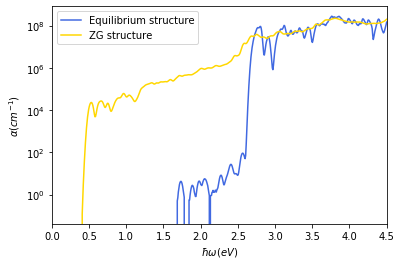

In [18]:
# Plot the absorption coefficient for the both systems
import matplotlib.pyplot as plt

si_zg.abs_calc
silicon_equil.abs_calc
data = np.loadtxt(str(os.getcwd())+'/'+f"si_zg/eps/abs.dat")
data2 = np.loadtxt(str(os.getcwd())+'/'+f"si_equil/eps/abs.dat")
plt.plot(data2[:, 0], data2[:, 1],color='royalblue', label='Equilibrium structure')
plt.plot(data[:, 0], data[:, 1],color='gold', label='ZG structure')
plt.xlim(0.0,4.5)
#plt.ylim(1e-3,1e2)
plt.yscale('log')
plt.legend()
plt.xlabel(r'$\hbar\omega (eV)$')
plt.ylabel(r'$\alpha(cm^{-1})$')
plt.show()

$\underline{\large{\rm Question}}$

Can you observe differences in the optical absorption? As an exercise, (i) investigate convergence of the spectra with respect to the k-point grid and (ii) investigate the temperature dependence of the spectra.